# <span style="color:orange"> Quantitative Comparison of Dipole Inversions algorithms // *For SC QSM* </span> </br>
This notebook uses masks and a ground truth chi map with STD in SC GM and WM to compare the accuracy of different DI algorithms developed for Brain QSM, this algorithms are mostly implemented in Sepia Toolbox: </br>
https://sepia-documentation.readthedocs.io/en/latest/index.html </br>

We will load the ground truth chimap, extract metrics and compare the offset of white matter and gray matter </br>

In the chimap, higher value relates to paramagnetic reaction to the magnetic field B0 whereas diamagnetic materials will show lower values on the map. </br>

Remember that this depends on the sign convention. We are using the rotating MR frame of reference where paramagnetic materials will show as positive and diamagnetic as negative.</br>

We have to offset the absolute chimap by the average of the Spinal Cord mask as SEPIA does this with the mask too! 



In [1]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import pandas as pd
from utils.extract_metric import extract_metrics

In [9]:
import utils.qsm_testing_display_slices
import importlib
importlib.reload(utils.qsm_testing_display_slices)

<module 'utils.qsm_testing_display_slices' from 'c:\\Users\\Admin\\Documents\\msc_project\\Image-processing-strategies\\qsm_testing\\utils\\qsm_testing_display_slices.py'>

## <span style="color:#EF9A9A"> Chi maps from the simulation after QSM pipeline</span> </br>
This use a Local Field calculated with:  </br>
Paramaters: 

In [3]:
# Load the mask data for metric auto-calculation with image
wm_mask_path = r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/wm_mask_crop.nii.gz"
gm_mask_path = r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/gm_mask_crop.nii.gz"
utils.qsm_testing_display_slices.load_gm_wm_masks(gm_mask_path, wm_mask_path)

In [4]:
gm_mask_data = nib.load(gm_mask_path).get_fdata()
wm_mask_data = nib.load(wm_mask_path).get_fdata()

### <span style="color:#B4A8D5"> Ground truth Local Field </span> </br>

In [5]:
# Lets first load the susceptibility ground truth map:
ground_truth_abs_chimap_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\sim_inputs\chi_to_fm_ppm/gauss_chi_sc_phantom_swiss_crop.nii.gz").get_fdata()
# Now we need to use the average of the spinal cord mask because this is what SEPIA averages to with the mask
sc_mask_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/cord_mask_crop.nii.gz").get_fdata()

avg_chi_sc_val = np.mean(ground_truth_abs_chimap_data[sc_mask_data==1])
print("Average chi value in spinal cord with std: ", avg_chi_sc_val)

# Now apply the offset to the ground truth map
chimap_ref_sc_avg_ = ground_truth_abs_chimap_data - avg_chi_sc_val

Average chi value in spinal cord with std:  -9.055173397504479


In [6]:
# Find the range for the chimap
abs_chimap_min = np.min(ground_truth_abs_chimap_data[sc_mask_data==1])
abs_chimap_max = np.max(ground_truth_abs_chimap_data[sc_mask_data==1])
print("Chimap min: ", abs_chimap_min)
print("Chimap max: ", abs_chimap_max)

Chimap min:  -9.122823000713478
Chimap max:  -8.924338035758733


In [7]:
# Now we apply the substraction of the chi average:
chimap_avg_sc_min = abs_chimap_min - avg_chi_sc_val
chimap_avg_sc_max = abs_chimap_max - avg_chi_sc_val

In [8]:
# Where the min is located:
chimap_ref_sc_avg_min_loc = np.unravel_index(np.argmin(chimap_ref_sc_avg_), chimap_ref_sc_avg_.shape)
print("Chimap min loc: ", chimap_ref_sc_avg_min_loc)

Chimap min loc:  (np.int64(156), np.int64(152), np.int64(30))


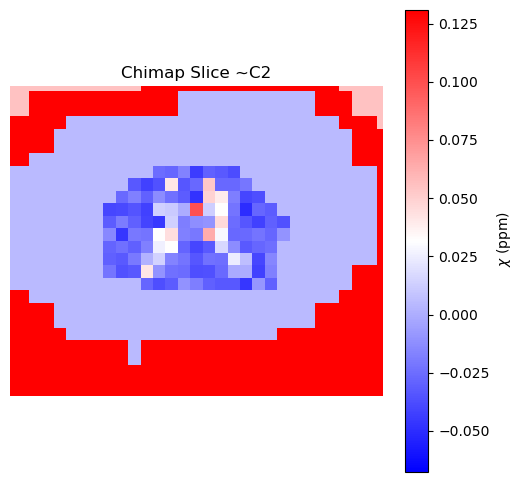

GM Mean: 0.0234 ppm
WM Mean: -0.0279 ppm


In [10]:
utils.qsm_testing_display_slices.display_qsm_slice(chimap_ref_sc_avg_, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

### <span style="color:#29B6F6"> TKD Results </span> </br>

In [11]:
initial_tkd_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_TKD\RMSE_test1_100_evals\tkd_run0/Sepia_Chimap.nii.gz").get_fdata()
best_tkd_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_TKD\RMSE_test1_100_evals\tkd_run98/Sepia_Chimap.nii.gz").get_fdata()

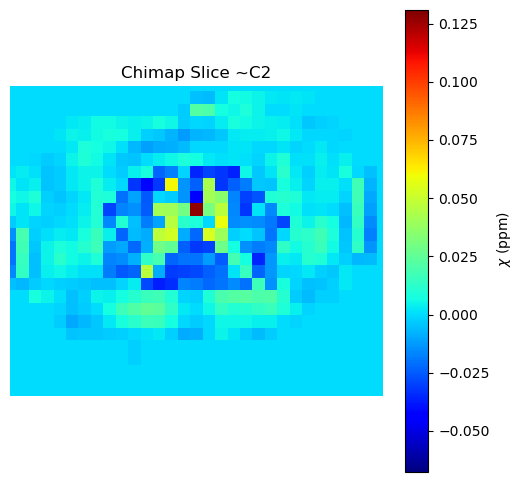

GM Mean: 0.0257 ppm
WM Mean: -0.0182 ppm


In [34]:
utils.qsm_testing_display_slices.display_qsm_slice(initial_tkd_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

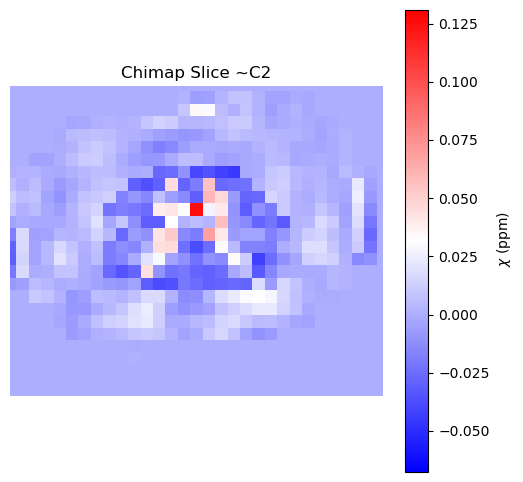

GM Mean: 0.0272 ppm
WM Mean: -0.0200 ppm


In [12]:
utils.qsm_testing_display_slices.display_qsm_slice(best_tkd_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

### <span style="color:#9EC771"> Closed-form Solution Results </span> </br>

In [13]:
initial_closed_form_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_closed_form\RMSE_test1_200_evals\closed_form_run0/Sepia_Chimap.nii.gz").get_fdata()
best__closed_form_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_closed_form\RMSE_test1_200_evals\closed_form_run95/Sepia_Chimap.nii.gz").get_fdata()

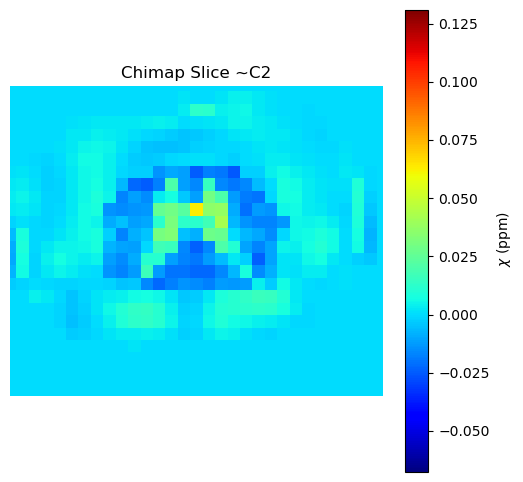

GM Mean: 0.0164 ppm
WM Mean: -0.0119 ppm


In [41]:
utils.qsm_testing_display_slices.display_qsm_slice(initial_closed_form_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

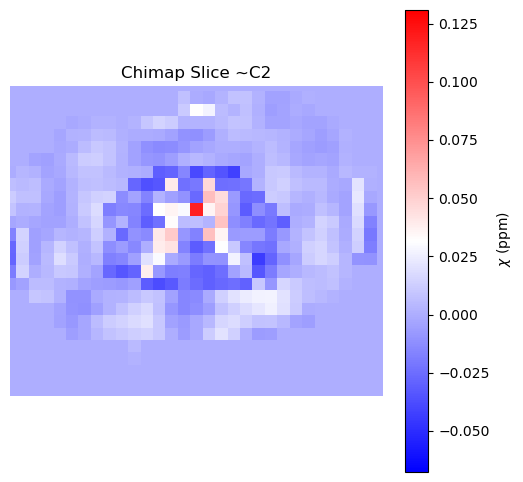

GM Mean: 0.0260 ppm
WM Mean: -0.0192 ppm


In [14]:
utils.qsm_testing_display_slices.display_qsm_slice(best__closed_form_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

In [46]:
# Comparing RMSE with the optimise flag on
closed_form_optimise_on_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\manual_configs\manual_closed_form\optimise_on/Sepia_Chimap.nii.gz").get_fdata()
tmp_pixelwise_difference = chimap_ref_sc_avg_ - closed_form_optimise_on_data
# Compute RMSE:
closed_form_optimise_on_wm = np.sqrt(np.mean((tmp_pixelwise_difference[wm_mask_data==1])**2))
closed_form_optimise_on_gm = np.sqrt(np.mean((tmp_pixelwise_difference[gm_mask_data==1])**2))
rmse_closed_form_optimise_on = closed_form_optimise_on_wm + closed_form_optimise_on_gm
print("RMSE closed form optimise on: ", rmse_closed_form_optimise_on)
print("RMSE closed form optimise on gm: ", np.sqrt(np.mean(closed_form_optimise_on_gm**2)))
print("RMSE closed form optimise on wm: ", np.sqrt(np.mean(closed_form_optimise_on_wm**2)))

RMSE closed form optimise on:  0.04102680027140708
RMSE closed form optimise on gm:  0.022401017858426006
RMSE closed form optimise on wm:  0.018625782412981073


### <span style="color:#FF5722"> iLSQR Results </span> </br>

In [15]:
initial_iLSQR_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_iLSQR\RMSE_test1_600_evals\iLSQR_run0/Sepia_Chimap.nii.gz").get_fdata()
best_iLSQR_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_iLSQR\RMSE_test1_600_evals\iLSQR_run332/Sepia_Chimap.nii.gz").get_fdata()

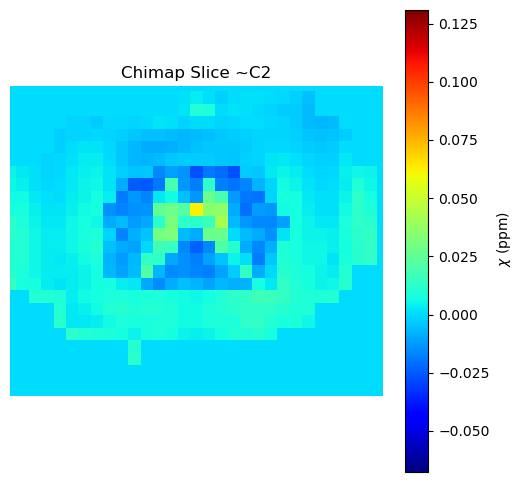

GM Mean: 0.0137 ppm
WM Mean: -0.0133 ppm


In [50]:
utils.qsm_testing_display_slices.display_qsm_slice(initial_iLSQR_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

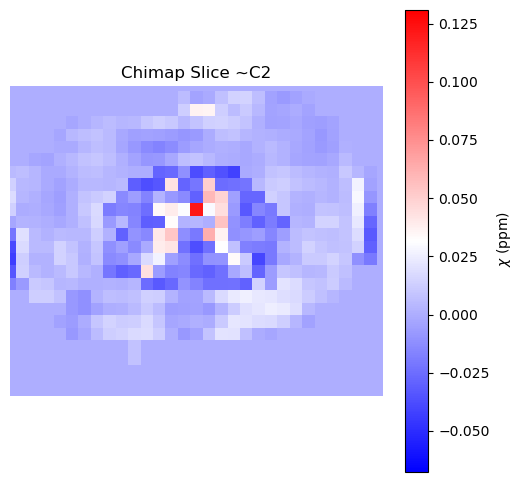

GM Mean: 0.0266 ppm
WM Mean: -0.0201 ppm


In [16]:
utils.qsm_testing_display_slices.display_qsm_slice(best_iLSQR_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

### <span style="color:#1565C0"> NDI Results </span> </br>

In [18]:
#initial_NDI_data = nib.load(r"").get_fdata()
best_NDI_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_NDI\RMSE_test1_with_mag_600_evals\NDI_run212/Sepia_Chimap.nii.gz").get_fdata()

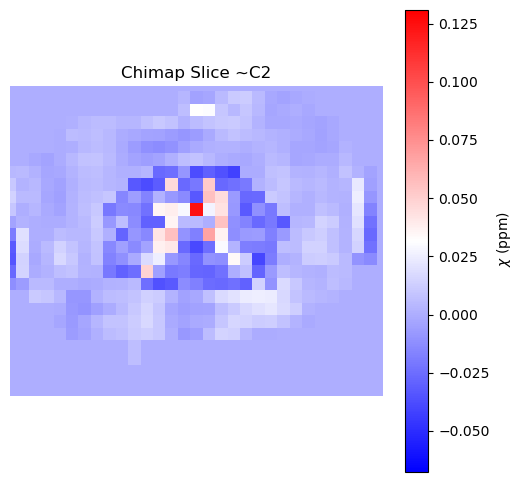

GM Mean: 0.0273 ppm
WM Mean: -0.0201 ppm


In [19]:
utils.qsm_testing_display_slices.display_qsm_slice(best_NDI_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

### <span style="color:#9575CD"> Star QSM Results </span> </br>

### <span style="color:#CE93D8"> FANSI Results </span> </br>


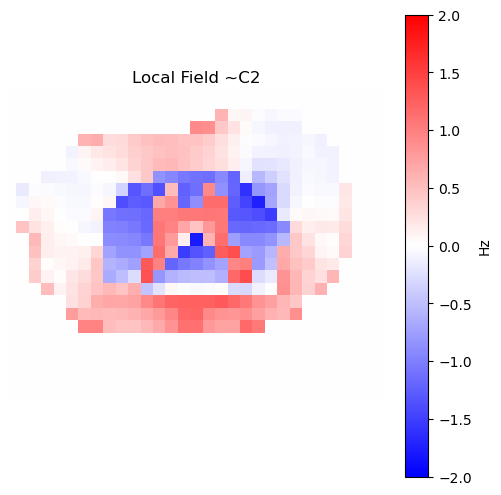

In [ ]:
utils.qsm_testing_display_slices.display_local_field(best_sharp_results_data, img_class="sim_ideal", slice_index=32, cmap_min=-2, cmap_max=2)

### <span style="color:#8D6E63"> MEDI Results </span> </br>


In [54]:
initial_MEDI_smv_on_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_MEDI\smv_on\RMSE_test1_with_mag_100_evals\MEDI_run0/Sepia_Chimap.nii.gz").get_fdata()
best_MEDI_smv_on_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_MEDI\smv_on\RMSE_test1_with_mag_100_evals\MEDI_run20/Sepia_Chimap.nii.gz").get_fdata()

In [59]:
best_MEDI_smv_off_test1_data = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\iter_MEDI\smv_off\RMSE_test1_with_mag_600_evals\MEDI_run2/Sepia_Chimap.nii.gz").get_fdata()

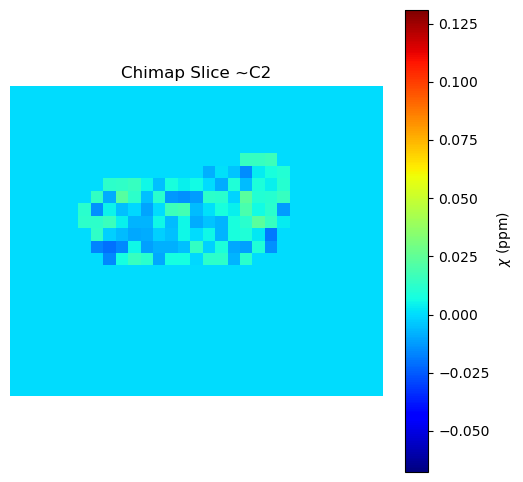

GM Mean: -0.0001 ppm
WM Mean: 0.0004 ppm


In [55]:
utils.qsm_testing_display_slices.display_qsm_slice(initial_MEDI_smv_on_data, img_class="sim_ideal", slice_index=32, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)

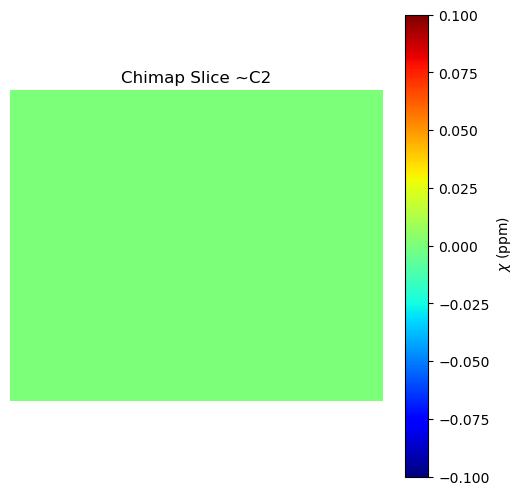

GM Mean: 0.0000 ppm
WM Mean: 0.0000 ppm


In [67]:
utils.qsm_testing_display_slices.display_qsm_slice(best_MEDI_smv_on_data, img_class="sim_ideal", slice_index=32, cmap_min=np.min(best_MEDI_smv_on_data), cmap_max=np.min(best_MEDI_smv_on_data))

In [64]:
np.min(best_MEDI_smv_off_test1_data)

np.float64(-3.257376945953183e-08)

In [65]:
np.max(best_MEDI_smv_off_test1_data)

np.float64(3.1864612282106464e-08)

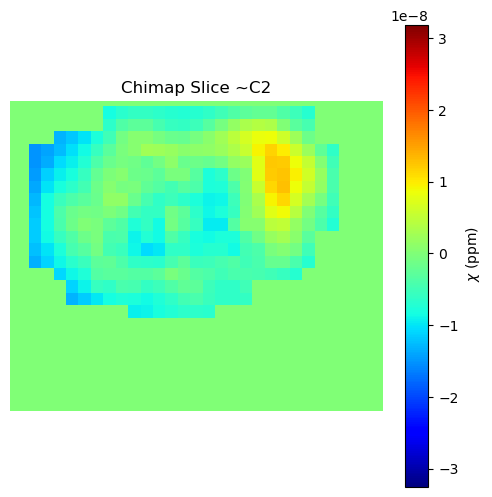

GM Mean: -0.0000 ppm
WM Mean: 0.0000 ppm


In [66]:
utils.qsm_testing_display_slices.display_qsm_slice(best_MEDI_smv_off_test1_data, img_class="sim_ideal", slice_index=29, cmap_min= np.min(best_MEDI_smv_off_test1_data), cmap_max=np.max(best_MEDI_smv_off_test1_data))

In [ ]:
initial_MEDI_smv_off_data = nib.load(r"").get_fdata()
best_MEDI_smv_off_data = nib.load(r"").get_fdata()

### <span style="color:#00897B"> MRI Suscep. Calc. Results </span> </br>

### <span style="color:#F06292"> LPCNN / xQSM / QSMnet+ Results </span> </br> 
Trying to run this 3 algos that don't have parameters but we can still compare to the default version

 </br>
 Examples of running the pipeline but with default versions of the algorithms
 

In [68]:
# First using PDF for BGFR in default mode and then using NDI in default for dipole inverision
default_comparison_chimap_data1 = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal\dipole_inversion_tests\manual_configs\bad_chimaps_for_comp\using_def_PDF_and_NDI/Sepia_Chimap.nii.gz").get_fdata()

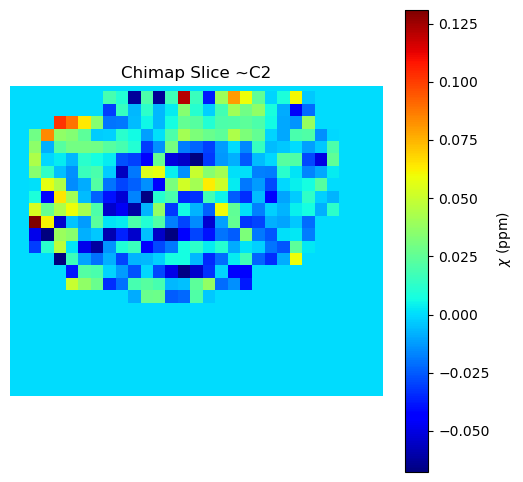

GM Mean: 0.0204 ppm
WM Mean: -0.0260 ppm


: 

In [ ]:
utils.qsm_testing_display_slices.display_qsm_slice(default_comparison_chimap_data1, img_class="sim_ideal", slice_index=29, cmap_min=chimap_avg_sc_min, cmap_max=chimap_avg_sc_max)